# 🟡Step 0: Imports


**Most Relevant Papers** <br />
https://arxiv.org/pdf/1407.5675.pdf <br />
https://arxiv.org/pdf/1701.08784.pdf

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


%matplotlib inline
from IPython.display import display
import time

# Possibly Redundant
from scipy import ndimage, misc
from skimage.feature import peak_local_max
from skimage import data, img_as_float

# 🟡Step 1: Read the data (tar.gz file)
As a first step, we unzipped the tar.gz file into a .dat file using 7-zip. 
Then, we convert the .dat file into a string and then into a DataFrame.

.strip() --> remove spaces on the sides

.split() --> separate values by spaces (otherwise we'd get a single conlumn)

In [2]:
# Convert .dat file into string (list comprehension)
datContent = [i.strip().split() for i in open("tth_semihad.dat").readlines()]

# Convert list into DataFrame
mydata = pd.DataFrame(datContent)

# 🟡Step 2: Explore the data
**Physics**

Jonas: "The file was produced from a simulation of pp->tt~H where the top decays hadronically
and the anti-top decays leptonically. <br /> I selected events with exactly 1 fat jet with R=1.5."


**Notes**
- The rows represent events (of 1 fat jet each, R = 1.5) 
- The first column represents the number of constituents of the jet  
- The following columns represent the coordinates of the constituents, η, φ, pT, cycling in that order. <br />(e.g. columns 1, 2, 3 are η, φ, pT for the 1st constituent, columns 4, 5, 6 are η, φ, pT for the 2nd constituent etc.)

<br />

- -infinity < η < infinity 
- -π < φ < π
- pT[GeV] > 0



In [3]:
# Display the data
mydata = mydata.rename(columns={0: 'Const'})
display(mydata.head())

# Print statements
rows = mydata.shape[0]
print('There are {} rows (events).'.format(rows))
print('The maximum number of constituents in an event is {}.'.format((mydata.shape[1] - 1) // 3))

# Display data types
#print('\nData Types: \n', mydata.dtypes)

# Descriptive statistics on data
#mydata.describe()

,Const,1,2,3,4,5,6,7,8,9,...,99,100,101,102,103,104,105,106,107,108
0,4,2.30474,0.221042,78.9436,1.00519,0.736657,61.9115,1.25546,0.748395,48.9755,...,None,None,None,None,None,None,None,None,None,None
1,2,2.35134,-2.18449,176.076,2.46233,-1.50073,47.3355,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,6,0.492933,0.766876,51.5247,-0.984489,2.29985,13.7463,0.103217,1.40088,5.31666,...,None,None,None,None,None,None,None,None,None,None
3,10,-0.624329,0.566723,130.197,-0.602316,0.573666,38.5226,-0.541426,0.449072,15.3244,...,None,None,None,None,None,None,None,None,None,None
4,15,-0.538961,-0.617644,0.819517,0.527734,1.53319,1.94989,0.20174,0.916744,5.63418,...,None,None,None,None,None,None,None,None,None,None


There are 12177 rows (events).
The maximum number of constituents in an event is 36.


# 🟡Step 3: Construct Average Jet Image

**Jonas:**

The data in each row represents all the constituents of a fat jet in the original (φ,η,pT) coordinate system of the detector. 
You should now transform all the constituents of one fat jet (i.e. individually for each row in the data file) into a new coordinate system 
(φ',η’,pT). Consequently you transform/bin this information into a two-dimensional image/Heat Map.   

The steps in detail are

1. Find the constituent with the highest pT
2. Choose the center of the new coordinate system such that this constituent has the coordinates (φ’,η’)=0. This operation corresponds to rotating and boosting along the beam direction to center the jet.  
3. Rotate all constituents around (φ’,η’)=0 such that the constituent with the 2nd highest pT is at 12 o’clock, i.e. at  (φ’,η’)=(0,e) with e > 0.
4. Flip all the constituents such that the constituents with the 3rd highest pT is on the right, i.e. at (φ’,η’)=(f,e) with f > 0
5. Define a 2-dim image with 40x40 pixels which correspond to η', φ' ∈ (−R, R). The jets we are looking at are approximately cone-shaped with radius R. I.e. all the constituents of the jet should end up within this image. For each pixel you now store the sum of the pT of all constituents that are located within this pixel. I.e. you discretise the (φ’,η’) coordinates into pixels and the intensity of the pixel corresponds to the sum of the energy of all constituents in the pixel.

As a very first step you can plot the images constructed from just steps 1)+2)+5) for a couple of jets. All the images will only have a few pixels filled. Subsequently you should plot the sum of all these images. This should give a broad peak at the center. 

Finally you should apply 1)-5) and plot the sum. This should hopefully look like the image from the reference. 



---

### 🔵 1. Extract Maxima
For each row, extract the maximum pT and its corresponding η and φ. <br />
We also extract the 2nd and 3rd maximum pT's for future use. 

🔴 Mild Prep

In [4]:
# Separate Constituents from Coordinates
const = mydata['Const']
mydata = mydata.drop('Const', axis=1)

# Replace NaN with 0
mydata = mydata.fillna(0)

# Convert values to floats
mydata = mydata.astype(float)

---

🔴 Separate pT and extract pT, φ, η 

In [5]:
# Separate η, φ, pT
hdata = mydata[mydata.columns[::3]]
fdata = mydata[mydata.columns[1::3]]
pdata1 = mydata[mydata.columns[2::3]]

In [6]:
start = time.time()
# 1. Extract column number of maximum pT
maxid1 = list(pdata1.idxmax(axis=1))
maxlist1 = []

# 2. Iterate through all rows(events) and all max pT columns to extract η, φ, pT
for i, j in zip(range(rows), maxid1):
    if pdata1.max(axis=1)[i] != 0:
        maxlist1.append([mydata.iloc[i, j-1], mydata.iloc[i, j-2], mydata.iloc[i, j-3]])
    else:
        maxlist1.append([0., mydata.iloc[i, j-2], mydata.iloc[i, j-3]])

# 3. Create & Display dataframe of maxima, η, φ
mydata_max1 = pd.DataFrame(maxlist1, columns=['pT', 'φ', 'η'])
#display(mydata_max1)


####################################################################################################################################


# 0. Set Max to 0
pdata2 = pdata1.copy(deep=True)
for i, j in zip(range(rows), maxid1):
    pdata2.loc[i, j] = 0
#display(pdata2)

# 1. Extract column number of maximum pT
maxid2 = list(pdata2.idxmax(axis=1))
maxlist2 = []
# 2. Iterate through all rows(events) and all max pT columns to extract η, φ, pT
for i, j in zip(range(rows), maxid2):
    if pdata2.max(axis=1)[i] != 0:
        maxlist2.append([mydata.iloc[i, j-1], mydata.iloc[i, j-2], mydata.iloc[i, j-3]])
    else:
        maxlist2.append([0., mydata.iloc[i, j-2], mydata.iloc[i, j-3]])

# 3. Create & Display dataframe of maxima, η, φ
mydata_max2 = pd.DataFrame(maxlist2, columns=['pT', 'φ', 'η'])
#display(mydata_max2)

####################################################################################################################################


# 0. Set Max to 0
pdata3 = pdata2.copy(deep=True)
for i, j in zip(range(rows), maxid2):
    pdata3.loc[i, j] = 0
#display(pdata3)

# 1. Extract column number of maximum pT
maxid3 = list(pdata3.idxmax(axis=1))
maxlist3 = []

# 2. Iterate through all rows(events) and all max pT columns to extract η, φ, pT
for i, j in zip(range(rows), maxid3):
    if pdata3.max(axis=1)[i] != 0:
        maxlist3.append([mydata.iloc[i, j-1], mydata.iloc[i, j-2], mydata.iloc[i, j-3]])
    else:
        maxlist3.append([0., mydata.iloc[i, j-2], mydata.iloc[i, j-3]])

# 3. Create & Display dataframe of maxima, η, φ
mydata_max3 = pd.DataFrame(maxlist3, columns=['pT', 'φ', 'η'])
#display(mydata_max3)

####################################################################################################################################

end = time.time()
print('Time taken to extract maxima: {0:.2f}s'.format(end - start))

Time taken to extract maxima: 29.26s


---

### 🔵2. Shift: Centre New Coordinate System
For each row, we centre a new coordinate system so that the highest pT constituent's coordinates are (φ', η') = (0, 0). <br />
This corresponds to rotating and boosting along the beam direction to center the jet.

How does η transform? We need a Lorentz Transformation. 

**Papers** (E) <br />
Histograms binned in
either the angular separation of events or the rapidity separation of events can
be contributed to by events whose centre of mass frames are boosted by arbitrary velocities with respect to the rest frame of the detector, the lab frame.
The resulting histograms are undistorted by these centre of mass frame boosts
parallel to the beam axis, as the dependent variable is invariant with respect
to this sub–class of Lorentz boosts.

Paper (F):

![image](h1.png)
![image](h2.png)

In [7]:
mydata

,1,2,3,4,5,6,7,8,9,10,...,99,100,101,102,103,104,105,106,107,108
0,2.304740,0.221042,78.943600,1.005190,0.736657,61.91150,1.255460,0.748395,48.97550,1.313450,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.351340,-2.184490,176.076000,2.462330,-1.500730,47.33550,0.000000,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.492933,0.766876,51.524700,-0.984489,2.299850,13.74630,0.103217,1.400880,5.31666,-1.033300,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.624329,0.566723,130.197000,-0.602316,0.573666,38.52260,-0.541426,0.449072,15.32440,-0.653142,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.538961,-0.617644,0.819517,0.527734,1.533190,1.94989,0.201740,0.916744,5.63418,0.225016,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12172,0.920302,-1.164120,2.733400,1.296590,-0.802425,31.02190,1.439240,-0.331847,41.04580,1.458750,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12173,-3.375520,0.408371,1.104380,-2.201780,-0.384944,9.30608,-2.200330,-0.250145,69.29370,-2.256840,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12174,1.392990,-0.378084,121.604000,0.581470,-0.162943,6.92172,0.480303,-0.159881,15.99220,0.283491,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12175,1.726060,2.992400,2.487510,1.110570,2.811820,1.12000,1.192300,2.665060,148.50200,1.248160,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# Create centred dataframe
mydata_prime = mydata.copy(deep=True)

start = time.time()

# Centre new coordinate system. i.e. For each row, subtract the φ of its max pT from all φ
for i, j, k in zip(range(rows), mydata_max1['η'], mydata_max1['φ']):
    mydata_prime.iloc[i][::3] -= j   # This was for η, but it shouldn't be transformed this way
    mydata_prime.iloc[i][1::3] -= k   # This is for φ 
    
end = time.time()
print('Time taken to centre new coordinate system: {0:.2f}s'.format(end - start))

Time taken to centre new coordinate system: 6.63s


In [9]:
mydata_prime

,1,2,3,4,5,6,7,8,9,10,...,99,100,101,102,103,104,105,106,107,108
0,2.304740,0.000000,78.943600,1.005190,0.515615,61.91150,1.255460,0.527353,48.97550,1.313450,...,0.0,0.0,-0.221042,0.0,0.0,-0.221042,0.0,0.0,-0.221042,0.0
1,2.351340,0.000000,176.076000,2.462330,0.683760,47.33550,0.000000,2.184490,0.00000,0.000000,...,0.0,0.0,2.184490,0.0,0.0,2.184490,0.0,0.0,2.184490,0.0
2,0.492933,-0.629554,51.524700,-0.984489,0.903420,13.74630,0.103217,0.004450,5.31666,-1.033300,...,0.0,0.0,-1.396430,0.0,0.0,-1.396430,0.0,0.0,-1.396430,0.0
3,-0.624329,0.000000,130.197000,-0.602316,0.006943,38.52260,-0.541426,-0.117651,15.32440,-0.653142,...,0.0,0.0,-0.566723,0.0,0.0,-0.566723,0.0,0.0,-0.566723,0.0
4,-0.538961,-0.922292,0.819517,0.527734,1.228542,1.94989,0.201740,0.612096,5.63418,0.225016,...,0.0,0.0,-0.304648,0.0,0.0,-0.304648,0.0,0.0,-0.304648,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12172,0.920302,-0.658336,2.733400,1.296590,-0.296641,31.02190,1.439240,0.173937,41.04580,1.458750,...,0.0,0.0,0.505784,0.0,0.0,0.505784,0.0,0.0,0.505784,0.0
12173,-3.375520,0.481575,1.104380,-2.201780,-0.311740,9.30608,-2.200330,-0.176941,69.29370,-2.256840,...,0.0,0.0,0.073204,0.0,0.0,0.073204,0.0,0.0,0.073204,0.0
12174,1.392990,0.000000,121.604000,0.581470,0.215141,6.92172,0.480303,0.218203,15.99220,0.283491,...,0.0,0.0,0.378084,0.0,0.0,0.378084,0.0,0.0,0.378084,0.0
12175,1.726060,0.327340,2.487510,1.110570,0.146760,1.12000,1.192300,0.000000,148.50200,1.248160,...,0.0,0.0,-2.665060,0.0,0.0,-2.665060,0.0,0.0,-2.665060,0.0


---

### 🔵3. Rotation: Rotate image such that 2nd max pT is at 12 o'clock
Rotate all constituents around (φ’,η’)=0 such that the constituent with the 2nd highest pT is at 12 o’clock, i.e. at  (φ’,η’)=(0,e) with e > 0.

**Paper (C)** <br />
"Rotation: Rotation is performed to remove the stochastic nature of the decay
angle relative to the η − φ coordinate system. This alignment can be done very
generally, by determining the principle axis [48] of the original image and rotating the imagine around the jet-energy centroid such that the principle axis
is always vertical."

#### Resources
https://stackoverflow.com/questions/53854066/pythonhow-to-rotate-an-image-so-that-a-feature-becomes-vertical

https://alyssaq.github.io/2015/computing-the-axes-or-orientation-of-a-blob/

https://pythontic.com/image-processing/pillow/rotate

https://www.askpython.com/python/examples/rotate-an-image-by-an-angle-in-python

https://www.pyimagesearch.com/2017/01/02/rotate-images-correctly-with-opencv-and-python/




---

### 🔵4. Flip: Flip image so that 3rd max pT is in right-half plane
Flip all the constituents such that the constituents with the 3rd highest pT is on the right, i.e. at (φ’,η’)=(f,e) with f > 0

---

### 🔵5. Create 40x40 Image
1. Define Data that will create the bins (η, φ) and will weigh the bins (pT)
2. Using the bins, create a 2D histogram using numpy's histogram2d()
3. Input the histogram as a DataFrame into Seaborn's heatmap()
4. Tadaaaa


---

🔴 Define Bins Data (for histogram in the next step)

This is done by combining all rows (events) into a single row for each coordinate (η, φ, pT). <br />

In [ ]:
# Initiate bin lists
bin_h = []
bin_f = []
bin_p = []

# Define max number of constituents 
max_const = mydata_prime.shape[1] // 3

#######################################################################################################################
# η Bin 
#######################################################################################################################

start = time.time()

# For all rows
for i in range(mydata_prime.shape[0]):             

    # For all constituents
    for j in range(max_const):
        # Add constituent's η to η bin
        bin_h.append(list(mydata_prime.loc[i][::3])[j])
        
end = time.time()

print('Time taken for bin_h: {0:.2f} seconds'.format(end-start))


#######################################################################################################################
# φ Bin 
#######################################################################################################################

start = time.time()

# For all rows
for i in range(mydata_prime.shape[0]):

    # For all constituents
    for j in range(max_const):
        # Add constituent's φ to φ bin
        bin_f.append(list(mydata_prime.loc[i][1::3])[j])
        
end = time.time()

print('Time taken for bin_f: {0:.2f} seconds'.format(end-start))

#######################################################################################################################
# pT Bin 
#######################################################################################################################

start = time.time()

# For all rows
for i in range(mydata_prime.shape[0]):

    # For all constituents
    for j in range(max_const):
        # Add constituent's pT to p bin
        bin_p.append(list(mydata_prime.loc[i][2::3])[j])
        
end = time.time()

print('Time taken for bin_p: {0:.2f} seconds'.format(end-start))

#######################################################################################################################

if (len(bin_h) == len(bin_f)) and (len(bin_f) == len(bin_p)):
    print('\nBin lengths match! :D')
else:
    print('\nBin lengths don\' match :  -  (')

Time taken for bin_h: 55.60 seconds


---

🔴 Create 2D Histogram 🔴 Create Heatmap

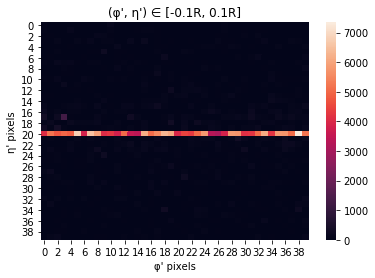

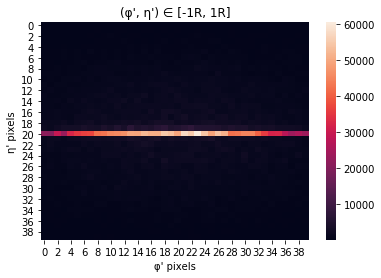

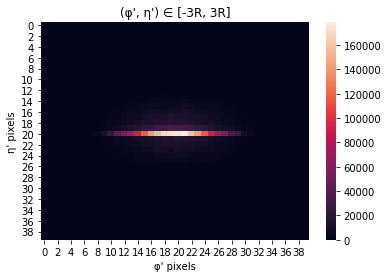

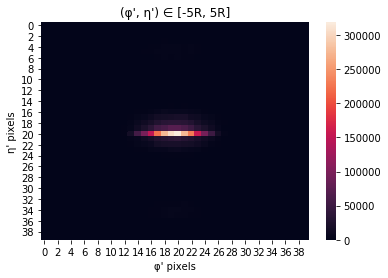

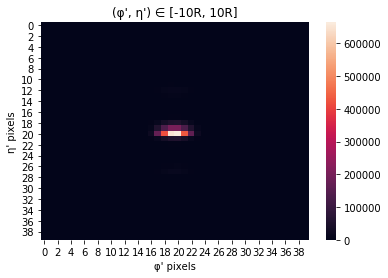

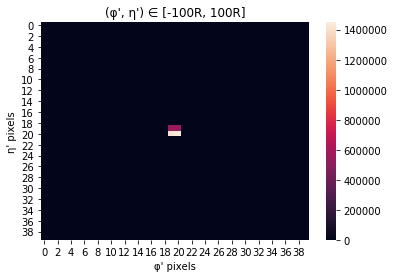

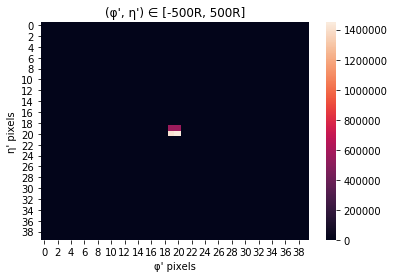

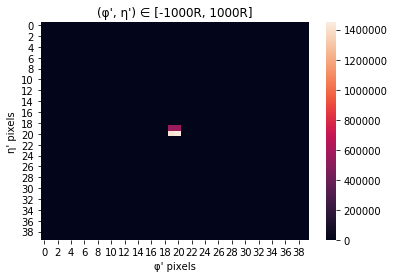

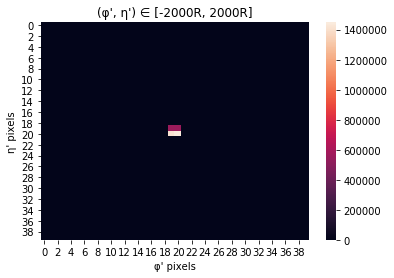

In [12]:
# Define bins data
bin_h = pd.Series(bin_h)
bin_f = pd.Series(bin_f)
bin_p = pd.Series(bin_p)

for i in [0.1, 1, 3, 5, 10, 100, 500, 1000, 2000]:
    # Define bins count vector (jet radius: R, image pixels: 40x40)
    R = 1.5
    pixels = 40
    bin_count = np.linspace(-i*R, i*R, pixels + 1)

    # Create bins from -R to R (using bins vector)
    bins = np.histogram2d(bin_f, bin_h, bins=bin_count, weights=bin_p)[0]

    # Convert to DataFrame
    bins = pd.DataFrame(bins)

    # Display Full bins DataFrame
    #display(bins)
    
    # Plot Heat Map
    sns.heatmap(bins)
    plt.title('(φ\', η\') ∈ [-{}R, {}R]'.format(i, i))
    plt.xlabel('φ\' pixels')
    plt.ylabel('η\' pixels')
    plt.show()

In [13]:
print(min(bin_h))
print(min(bin_f))
print(max(bin_h))
print(max(bin_f))

-4.52544
-6.27778
4.37115
6.2694600000000005


# With Tranfromed η (not lorentz-transformed, so probably incorrect)

In [ ]:
# Define bins data
bin_h = pd.Series(bin_h)
bin_f = pd.Series(bin_f)
bin_p = pd.Series(bin_p)

for i in [0.1, 1, 3, 5, 10, 100, 500, 1000, 2000]:
    # Define bins count vector (jet radius: R, image pixels: 40x40)
    R = 1.5
    pixels = 40
    bin_count = np.linspace(-i*R, i*R, pixels + 1)

    # Create bins from -R to R (using bins vector)
    bins = np.histogram2d(bin_f, bin_h, bins=bin_count, weights=bin_p)[0]

    # Convert to DataFrame
    bins = pd.DataFrame(bins)

    # Display Full bins DataFrame
    #display(bins)
    
    # Plot Heat Map
    sns.heatmap(bins)
    plt.title('(φ\', η\') ∈ [-{}R, {}R]'.format(i, i))
    plt.xlabel('φ\' pixels')
    plt.ylabel('η\' pixels')
    plt.show()

In [ ]:
print(min(bin_h))
print(min(bin_f))
print(max(bin_h))
print(max(bin_f))

---

🔴


---